In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 310bffb3-c918-41d5-957e-fe37de1934e6

In [16]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from tqdm import tqdm
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [40]:
# set variables here
ul, ur = 100,100
interval = 20

 
Ts = 0.1
thymio_data = []

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

def get_data():
    thymio_data.append({"ground":list(node["prox.ground.reflected"]), 
                        "sensor":list(node["prox.ground.reflected"]),
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"],
                        "acc":list(node["acc"])})

await node.wait_for_variables() # wait for Thymio variables values
rt = RepeatedTimer(Ts, get_data) # it auto-starts, no need of rt.start()

node.send_set_variables(motors(ul,ur))
await client.sleep(interval) # your long-running job goes here...


rt.stop() # better in a try/finally block to make sure the program ends!
node.send_set_variables(motors(0, 0))


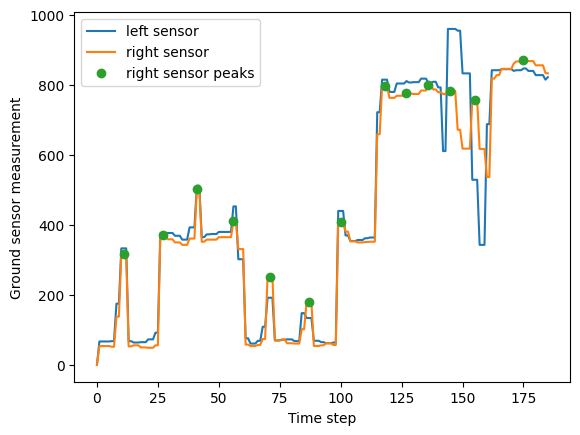

In [38]:
l_sensor = [x["ground"][0] for x in thymio_data]
r_sensor = [x["ground"][1] for x in thymio_data]
avg_ground = [(l+r)/2 for l, r in zip(l_sensor, r_sensor)]
r_peaks = find_peaks(r_sensor,100)[0]

plt.plot(l_sensor, label="left sensor")
plt.plot(r_sensor, label="right sensor")
plt.plot(r_peaks, [r_sensor[idx] for idx in r_peaks], "o", label = "right sensor peaks")
plt.xlabel("Time step")
plt.ylabel("Ground sensor measurement")
plt.legend()

In [41]:
thymio_mms_speed = 6*50/Ts/(r_peaks[6]-r_peaks[0])
print("The Thymio's speed in mm/s is {}".format(thymio_mms_speed))
thymio_speed_to_mms = thymio_mms_speed/50
print("To go from Thymio speed to mm/s, the conversion factor is {}".format(thymio_speed_to_mms))

The Thymio's speed in mm/s is 33.70786516853933
To go from Thymio speed to mm/s, the conversion factor is 0.6741573033707866


(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1., 29., 52., 72., 28.]),
 array([  0.  ,   5.55,  11.1 ,  16.65,  22.2 ,  27.75,  33.3 ,  38.85,
         44.4 ,  49.95,  55.5 ,  61.05,  66.6 ,  72.15,  77.7 ,  83.25,
         88.8 ,  94.35,  99.9 , 105.45, 111.  ]),
 <BarContainer object of 20 artists>)

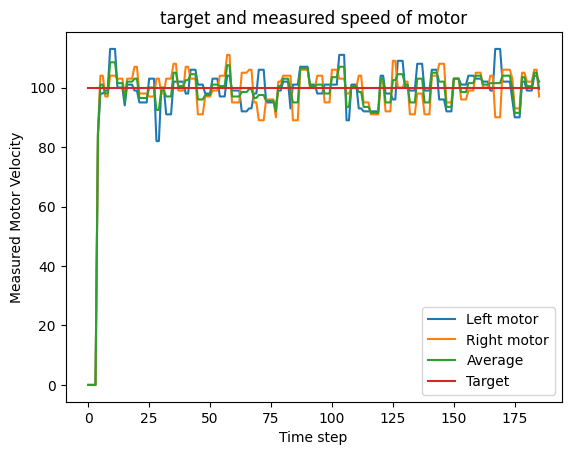

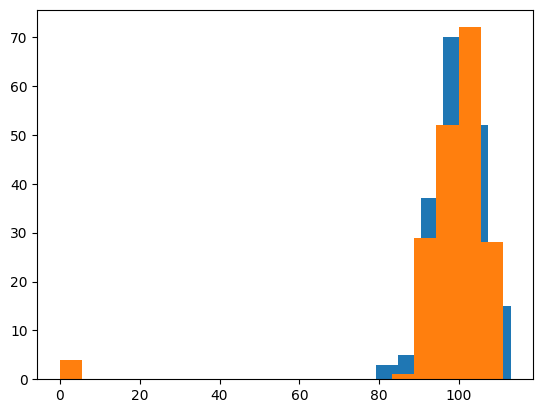

In [42]:
l_speed = [x["left_speed"] for x in thymio_data]
r_speed = [x["right_speed"] for x in thymio_data]
avg_speed = [(x["left_speed"]+x["right_speed"])/2 for x in thymio_data]
target_speed = [ul for x in thymio_data]
plt.figure()
plt.plot(l_speed, label="Left motor")
plt.plot(r_speed, label="Right motor")
plt.plot(avg_speed, label="Average")
plt.plot(target_speed, label="Target")
plt.xlabel("Time step")
plt.ylabel("Measured Motor Velocity")
plt.title("target and measured speed of motor")
plt.legend()
#plt.savefig(f"{ul},{ur},{interval}.png")


plt.figure()
plt.hist(l_speed, bins=20, label="left motor speed")
plt.hist(r_speed, bins=20, label="right motor speed")
#plt.savefig(f"{ul},{ur},{interval} hist.png")

The speed variance in mm^2/s^2 is 66.08658951092264, 67.50769159741456


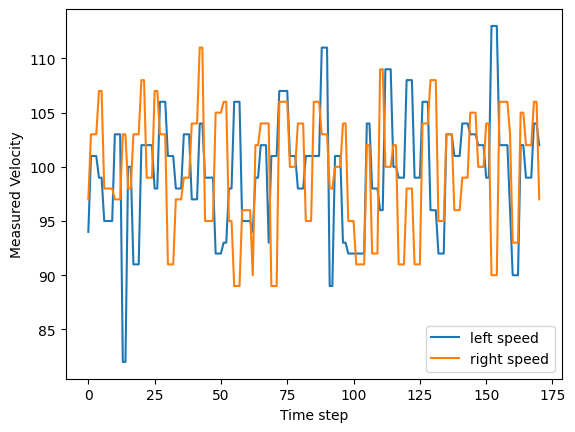

In [45]:
# choose idx to crop the data from visual inspection of the graph
idx=15
plt.plot(l_speed[idx:], label="left speed")
plt.plot(r_speed[idx:], label="right speed")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()
var_l_speed = np.var(l_speed[idx:]/thymio_speed_to_mms) # took from 55 to avoid the initial transient and devid by the conversion factor
var_r_speed = np.var(r_speed[idx:]/thymio_speed_to_mms)

print(f"The speed variance in mm^2/s^2 is {var_l_speed}, {var_r_speed}")

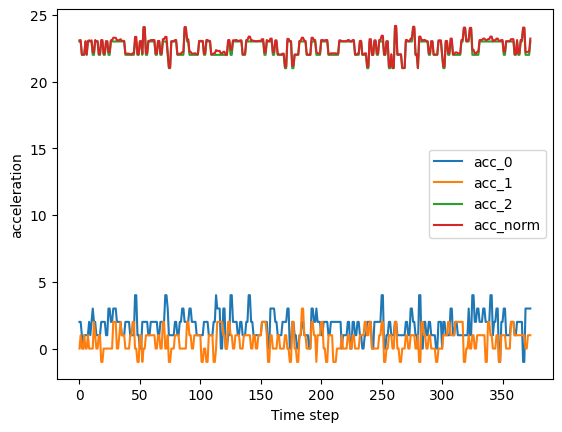

In [8]:
acc_0 = np.array([x["acc"][0] for x in thymio_data])
acc_1 = np.array([x["acc"][1] for x in thymio_data])
acc_2 = np.array([x["acc"][2] for x in thymio_data])
acc_norm = np.sqrt(acc_0**2 + acc_1**2 + acc_2**2)

plt.plot(acc_0, label="acc_0")
plt.plot(acc_1, label="acc_1")
plt.plot(acc_2, label="acc_2")
plt.plot(acc_norm, label="acc_norm")


plt.xlabel("Time step")
plt.ylabel("acceleration")
plt.legend()

In [19]:
await node.unlock()

In [20]:
await node.lock()
node.send_set_variables(motors(0,0))